# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,stand,59,0.3608677355979031,2.7655574767746303,0.20870629032593843,0.6581472034160547,...,-1.5096047609935206,0.5374402120462101,0.24725567691914474,-1.1548519667455222,-0.9176895137907444,0.19853266525825441,-0.6351422949522179,-0.9240468871850966,-0.6043028159859238,-0.40440680981149635
1,101,0,2,1,stand,44,0.11857848631771781,2.2982802008603884,0.22148909073910306,0.8313514219454735,...,-1.280617105642371,0.7268055218978855,-1.7517830977424425,-0.7701703570143632,0.4187723636318532,1.0481449056142007,-0.9030033089456406,-0.19860783889835965,0.8934212147732565,-0.276497605679932
2,101,0,3,1,stand,53,0.24619052972163322,3.445303563459787,0.20016295285928792,0.9602665690153961,...,-1.4552465068519256,0.1405061114156383,0.7198891878500557,-0.5806536048592652,-0.76127983523148,-0.3931234568509234,0.412760624339358,-1.007601590228747,-0.4138693928861996,-0.5305323879118911
3,101,0,4,1,stand,57,0.28321350295077613,3.626021938955907,0.3449046585971368,0.5731684465708434,...,-1.51459552588099,1.0602340465863236,0.4958653590427531,-0.13640312363512264,-0.5844906010216535,-0.6109341257432597,-1.3306916169093075,-1.4875437672995169,-1.2588076707533085,-0.057357413926721
4,101,0,5,1,stand,60,0.39363598833851376,3.767306517718122,0.2176579492233252,0.6589984240898876,...,-1.3601464899179059,-1.527706279445947,0.39390720825161907,-0.42688443195923,-0.5349520236928611,-1.1701446029912246,-0.8445014311637222,-1.4273439546363045,-0.33874666284848587,-0.32227339359147944


## 1. Preprocesado

### 1.1 Codificar variables

In [3]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [4]:
# Dividimos los datos en varibales independientes y en target
X = df.drop(['GestureLabel'], axis = 1)
y = pd.DataFrame(df['GestureLabel'])

# Dividimos en train y test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)    

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()


## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [5]:
#-------Funcion para evaluar los modelos-----------
def test_models(modelos, tX, ty):
   for modelo in modelos:
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 


In [6]:
knn = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr = LogisticRegression(max_iter = 3000) # ¿o usar StandardScaler?

models = [knn, dtree, nb, svm, rf, lr]

for modelo in models:
    modelo.fit(train_X, train_y) # entrenamos el modelo
    
# entrenamiento + evaluación
test_models(models, test_X, test_y)

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        77
           1       0.96      0.92      0.94        84
           2       0.81      0.83      0.82       113
           3       0.74      0.76      0.75        96
           4       0.79      0.81      0.80        83
           5       0.70      0.68      0.69        77
           6       0.99      0.88      0.93        78
           7       0.84      0.85      0.85        82
           8       0.88      0.89      0.88        87

    accuracy                           0.84       777
   macro avg       0.84      0.84      0.84       777
weighted avg       0.84      0.84      0.84       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.96      0.90      0.93        84
           2       0.87      0.96      0.92       113
           3    

En la mayoría de ejecutiones los mejores son **DecisionTreeClassifier**, **KNeighborsClassifier** o **Regresión logistica**

In [7]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """

    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title('Confusion Matrix ' + modelo.__class__.__name__)
    plt.show()


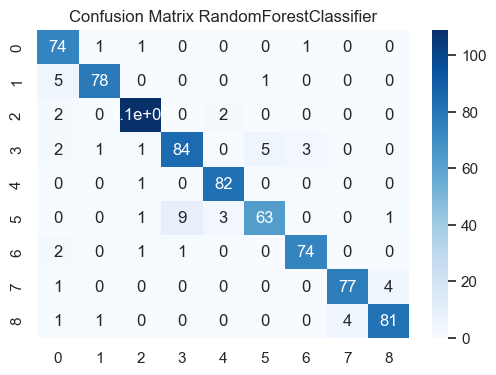

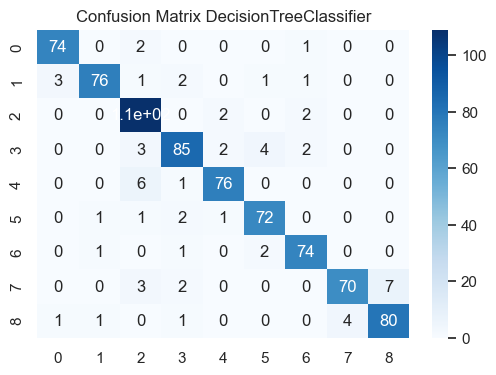

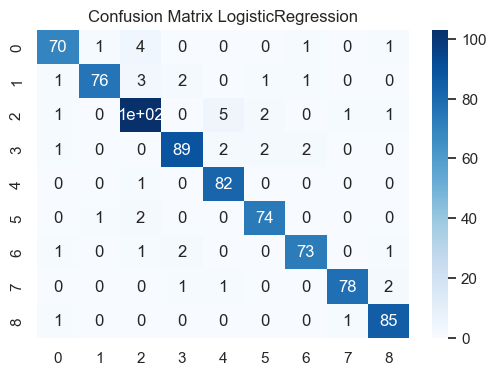

In [8]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(rf, test_X, test_y)
plot_confusion_matrix(dtree, test_X, test_y)
plot_confusion_matrix(lr, test_X, test_y)

## 3. Hipermetrización

In [9]:
#-------------Parametros---------------
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [10]:
def aplicar_hiperparametrizacion(X, y):
    gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
    gs_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid_dtree, cv=5, scoring='accuracy')
    gs_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy')
    gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
    gs_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

    modelos = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

    best_models = []
    for modelo in modelos:
        modelo.fit(X, y)
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        # print(modelo.cv_results_) 
        print("Best parameters: ", modelo.best_params_)
        print("Best score: ", modelo.best_score_)
        best_models.append(modelo.best_estimator_)
    return best_models
    

In [11]:
best_models = aplicar_hiperparametrizacion(train_X, train_y)


Modelo: KNeighborsClassifier
Best parameters:  {'n_neighbors': 1}
Best score:  0.8449264112749798

Modelo: DecisionTreeClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 40}
Best score:  0.9127939363499383

Modelo: GaussianNB
Best parameters:  {'var_smoothing': 2.310129700083158e-06}
Best score:  0.757173949439143

Modelo: SVC
Best parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.9453556154209093

Modelo: RandomForestClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 100}
Best score:  0.9608160966774729


In [12]:
test_models(best_models, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        77
           1       0.96      0.92      0.94        84
           2       0.81      0.83      0.82       113
           3       0.74      0.76      0.75        96
           4       0.79      0.81      0.80        83
           5       0.70      0.68      0.69        77
           6       0.99      0.88      0.93        78
           7       0.84      0.85      0.85        82
           8       0.88      0.89      0.88        87

    accuracy                           0.84       777
   macro avg       0.84      0.84      0.84       777
weighted avg       0.84      0.84      0.84       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        77
           1       0.97      0.90      0.94        84
           2       0.89      0.96      0.92       113
           3    

## 4. Feature Selection

### 4.1 SelectKBest

In [13]:
# Definimos feature Selection K=40 (selecciona entonces las 40 variables que considere mas importantes)
feature_selection=SelectKBest(k=40)

# Fit Feature Selection (entrena y hace una tranfosmada)
feature_selection.fit_transform(train_X, train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)
print(train_X.columns[selected])

Index(['RightArmAngle_standardDeviation', 'ElbowAngleRight_standardDeviation',
       'LeftArmAngle_standardDeviation',
       'ShoulderAngleRight_standardDeviation',
       'ElbowAngleLeft_standardDeviation',
       'ShoulderAngleLeft_standardDeviation',
       'HipAngleRight_standardDeviation',
       'ArmsTogetherAngle_standardDeviation', 'ElbowAngleRight_Maximum',
       'ShoulderAngleRight_Maximum', 'ElbowAngleLeft_Maximum',
       'ShoulderAngleLeft_Maximum', 'RightArmAngle_Minimum',
       'LeftArmAngle_Minimum', 'ShoulderAngleLeft_Minimum',
       'ArmsTogetherAngle_Minimum', 'RightArmAngle_Mean', 'LeftArmAngle_Mean',
       'ShoulderAngleLeft_Mean', 'ArmsTogetherAngle_Mean',
       'RightArmAngle_Range', 'ElbowAngleRight_Range', 'LeftArmAngle_Range',
       'ShoulderAngleRight_Range', 'ElbowAngleLeft_Range',
       'ShoulderAngleLeft_Range', 'ArmsTogetherAngle_Range',
       'RightArmAngle_Variance', 'ElbowAngleRight_Variance',
       'LeftArmAngle_Variance', 'ElbowAngleLeft_V

### 4.2 Entrenar con las variables sleccionadas

In [14]:
# creación de los modelos
knn_fs = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_fs = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs, lr_fs]


In [15]:
# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(feature_selection.transform(train_X),
                 columns=train_X.columns[selected])
# train -> train and validation
X_fs_train, X_validation, y_fs_train, y_validation = train_test_split(X_fs, train_y, train_size=0.7,random_state=42)

for modelo in models_fs:
        modelo.fit(X_fs_train, y_fs_train)

test_models(models_fs, X_validation, y_validation)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        48
           1       0.97      0.97      0.97        59
           2       0.68      0.75      0.71        72
           3       0.70      0.84      0.77        64
           4       0.67      0.63      0.65        63
           5       0.81      0.69      0.75        62
           6       0.97      0.95      0.96        65
           7       0.91      0.89      0.90        56
           8       0.88      0.78      0.83        55

    accuracy                           0.82       544
   macro avg       0.83      0.82      0.82       544
weighted avg       0.82      0.82      0.82       544


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        48
           1       0.87      0.90      0.88        59
           2       0.80      0.96      0.87        72
           3    

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
for modelo in best_models:
        modelo.fit(X_fs_train, y_fs_train)
test_models(best_models, X_validation, y_validation)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        48
           1       0.97      0.97      0.97        59
           2       0.68      0.75      0.71        72
           3       0.70      0.84      0.77        64
           4       0.67      0.63      0.65        63
           5       0.81      0.69      0.75        62
           6       0.97      0.95      0.96        65
           7       0.91      0.89      0.90        56
           8       0.88      0.78      0.83        55

    accuracy                           0.82       544
   macro avg       0.83      0.82      0.82       544
weighted avg       0.82      0.82      0.82       544


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        48
           1       0.92      0.92      0.92        59
           2       0.82      0.92      0.87        72
           3    

### 4.3 Recursive feature elimination

In [17]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_rfe = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models_with_coef = [dtree_rfe, rf_rfe]

In [18]:
def seleccion_variables(models, X, y):
    for model in models:
        rfecv = RFECV(
            estimator=model,
            scoring="accuracy",
            n_jobs=2 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y)
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Optimal number of features: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        
        X_rfe= train_X[selected]
        # train -> train and validation
        X_rfe_train, X_validation, y_rfe_train, y_validation = train_test_split(X_rfe, y, train_size=0.7,random_state=42)
        model.fit(X_rfe_train, y_rfe_train, )
        test_models([model], X_validation, y_validation)

seleccion_variables(models_with_coef, train_X, train_y)


Modelo: DecisionTreeClassifier
Optimal number of features: 24
['RepetitionNumber' 'HipAngleLeft_standardDeviation'
 'AnkleAngleLeft_standardDeviation' 'KneeAngleRight_standardDeviation'
 'ElbowAngleRight_standardDeviation' 'RightArmAngle_Maximum'
 'ShoulderAngleRight_Maximum' 'ShoulderAngleLeft_Maximum'
 'HipAngleRight_Maximum' 'ArmsTogetherAngle_Maximum'
 'RightArmAngle_Minimum' 'LeftArmAngle_Minimum'
 'ArmsTogetherAngle_Minimum' 'RightArmAngle_Mean' 'LeftArmAngle_Mean'
 'HipAngleLeft_Range' 'KneeAngleLeft_Range' 'ElbowAngleRight_Range'
 'RightArmAngle_Variance' 'ShoulderAngleRight_Variance'
 'ElbowAngleLeft_Variance' 'LeftArmAngle_CoV' 'ArmsTogetherAngle_CoV'
 'ShoulderAngleLeft_Skewness']

Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        48
           1       0.93      0.95      0.94        59
           2       0.87      0.96      0.91        72
           3       0.87      0.86      0.87      